# Variational Quantum Optimization using CVaR

## Introduction

This notebook shows how to use the Conditional Value at Risk (CVaR) objective function introduced in [1] within the variational quantum optimization algorithms provided by Qiskit, particularly `VQE` used within the `MinimumEigenOptimizer`. For a given set of shots and corresponding objective values, the CVaR with confidence level $\alpha \in [0, 1]$ is defined as the average of the $\alpha$ best shots.
Thus, $\alpha = 1$ corresponds to the standard expected value, while $\alpha=0$ corresponds to the minimum of the given shots.


## References

[1] https://arxiv.org/abs/1907.04769.

In [17]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE, QAOA
from qiskit.aqua.operators import PauliExpectation, CVaRExpectation
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import LinearEqualityToPenalty
from qiskit.optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit import execute, Aer

import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

In [18]:
########################
from qiskit import IBMQ
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider('ibm-q-internal', 'deployed', 'default')
hw_backend = provider.get_backend('ibmq_paris')
########################

ibmqfactory.load_account:WARNING:2020-10-07 21:56:54,171: Credentials are already in use. The existing account in the session will be replaced.


## Portfolio Optimization
In the following we define a problem instance for portfolio optimization as introduced in [1].<br>

In [2]:
# prepare problem instance
n = 6  # number of assets
q = 0.5 # risk factor
budget = n // 2  # budget
penalty = 2*n # scaling for penalty term

In [3]:
# instance from [1]
mu = np.array([0.7313, 0.9893, 0.2725, 0.8750, 0.7667, 0.3622])
sigma = np.array([
    [ 0.7312, -0.6233,  0.4689, -0.5452, -0.0082, -0.3809],
    [-0.6233,  2.4732, -0.7538,  2.4659, -0.0733,  0.8945],
    [ 0.4689, -0.7538,  1.1543, -1.4095,  0.0007, -0.4301],
    [-0.5452,  2.4659, -1.4095,  3.5067,  0.2012,  1.0922],
    [-0.0082, -0.0733,  0.0007,  0.2012,  0.6231,  0.1509],
    [-0.3809,  0.8945, -0.4301,  1.0922,  0.1509,  0.8992]
])

# or random instance
# mu, sigma = portfolio.random_model(n, seed=123)  # expected returns and covariance matrix

In [4]:
# create docplex model
mdl = Model('portfolio_optimization')
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))
objective = mdl.sum([mu[i]*x[i] for i in range(n)])
objective -= q * mdl.sum([sigma[i,j]*x[i]*x[j] for i in range(n) for j in range(n)])
mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)

# case to 
qp = QuadraticProgram()
qp.from_docplex(mdl)

In [5]:
# we convert the problem to an unconstrained problem for further analysis,
# otherwise this would not be necessary as the MinimumEigenSolver would do this 
# translation automatically
linear2penalty = LinearEqualityToPenalty(penalty=penalty)
qp = linear2penalty.convert(qp)
_, offset = qp.to_ising()

In [6]:
# solve with CPLEX as reference
opt_result = CplexOptimizer().solve(qp)
opt_result

optimal function value: 1.2783500000000316
optimal value: [1. 1. 0. 0. 1. 0.]
status: INFEASIBLE

## Minimum Eigen Optimizer using VQE

In [7]:
# set classical optimizer
maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

# set variational ansatz
var_form = RealAmplitudes(n, reps=1)
m = var_form.num_parameters

# set backend
backend_name = 'qasm_simulator'  # use this for QASM simulator
# backend_name = 'statevector_simulator'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)  

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25]  # confidence levels to be evaluated
initial_point = np.random.rand(m)  # same random initial set of parameters for all experiments
pauli_exp = PauliExpectation()

In [19]:
######################
backend = hw_backend
alphas = [0.25]
######################

In [ ]:
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    objectives[alpha] += [-(obj + offset)]  # we translate the objective to the original problem
    print(i, obj)

# loop over all given alpha values
for alpha in alphas:
    
    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, pauli_exp)
    
    # initialize VQE
    vqe = VQE(expectation=cvar_exp, optimizer=optimizer, var_form=var_form, quantum_instance=backend,
             callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha))
   
    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(vqe)

    # solve problem
    results[alpha] = opt_alg.solve(qp)
    print('alpha = {}:'.format(alpha))
    print(results[alpha])
    print()

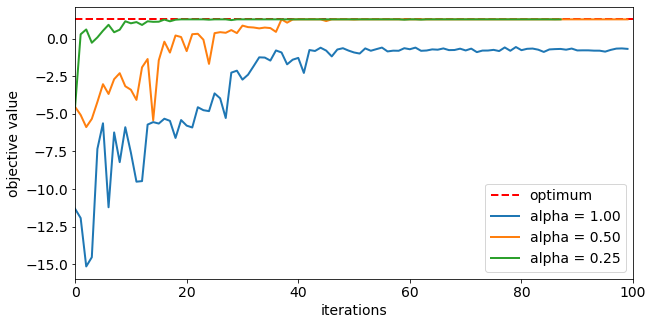

In [9]:
# plot resulting history of objective values - note that this 
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], 'r--', linewidth=2, label='optimum')
for alpha in alphas:
    plt.plot(objectives[alpha], label='alpha = %.2f' % alpha, linewidth=2)
plt.legend(loc='lower right', fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel('iterations', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('objective value', fontsize=14)
plt.show()

In [10]:
# evaluate and sort all objective values
objective_values = np.zeros(2**n)
for i in range(2**n):
    x_bin = ('{0:0%sb}' % n).format(i)
    x = [0 if x_ == '0' else 1 for x_ in reversed(x_bin)]
    objective_values[i] = qp.objective.evaluate(x)
ind = np.argsort(objective_values)

# evaluate final optimal probability for each alpha
probabilities = np.zeros(len(objective_values))
for alpha in alphas:
    if backend_name == 'qasm_simulator':
        counts = results[alpha].min_eigen_solver_result.eigenstate
        shots = sum(counts.values())
        for key, val in counts.items():
            i = int(key, 2)
            probabilities[i] = val / shots
    else:
        probabilities = np.abs(results[alpha].min_eigen_solver_result.eigenstate)**2
    print('optimal probabilitiy (alpha = %.2f):  %.4f' % (alpha, probabilities[ind][-1:]))

optimal probabilitiy (alpha = 1.00):  0.0000
optimal probabilitiy (alpha = 0.50):  0.5537
optimal probabilitiy (alpha = 0.25):  0.2871


In [11]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright